In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from pymc3 import Model, Normal, traceplot, Lognormal, sample, Deterministic, Uniform, df_summary, find_MAP, NUTS, summary

In [44]:
np.random.seed(0)
# Create Data for modelling

# Subject ID's
data = pd.DataFrame(np.arange(1,31), columns=['subject'])
# Dose
data['dose'] = np.array([100,100,100,100,100,100,100,100,100,100,
                        200,200,200,200,200,200,200,200,200,200,
                        300,300,300,300,300,300,300,300,300,300])
# Random Body Weight
data['WT'] = np.random.randint(50,100, size =30)
# Fixed Clearance and Volume for the population
data['CLpop'] =2
data['Vpop']=10
# Error rate for individual clearance rate
OMEGA = 0.66
# Individual clearance rate as a function of weight and omega
data['CLi'] = data['CLpop']*(data['WT']/70)+ np.random.normal(0, OMEGA )
# Individual Volume as a function of weight
data['Vi'] = data['Vpop']*(data['WT']/70) 

# Expand dataframe to account for time points
data = pd.concat([data]*6,ignore_index=True )
data = data.sort('subject')
# Add in time points
data['time'] = np.tile(np.array([0,1,2,4,8,12]), 30)

# Create concentration values using model
data['Cpred'] = data['dose']/data['Vi'] *np.exp(-1*data['CLi']/data['Vi']*data['time'])
# Error rate for DV
SIGMA = 0.33
# Create Dependenet Variable from Cpred + error
data['DV']= data['Cpred'] + np.random.normal(0, SIGMA )

# Create new df with only data for modelling...
df = data[['subject','dose','WT', 'time', 'DV']]
df.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,subject,dose,WT,time,DV
0,1,100,94,0,7.556921
60,1,100,94,1,6.075477
90,1,100,94,2,4.888747
30,1,100,94,4,3.176573
150,1,100,94,8,1.372825


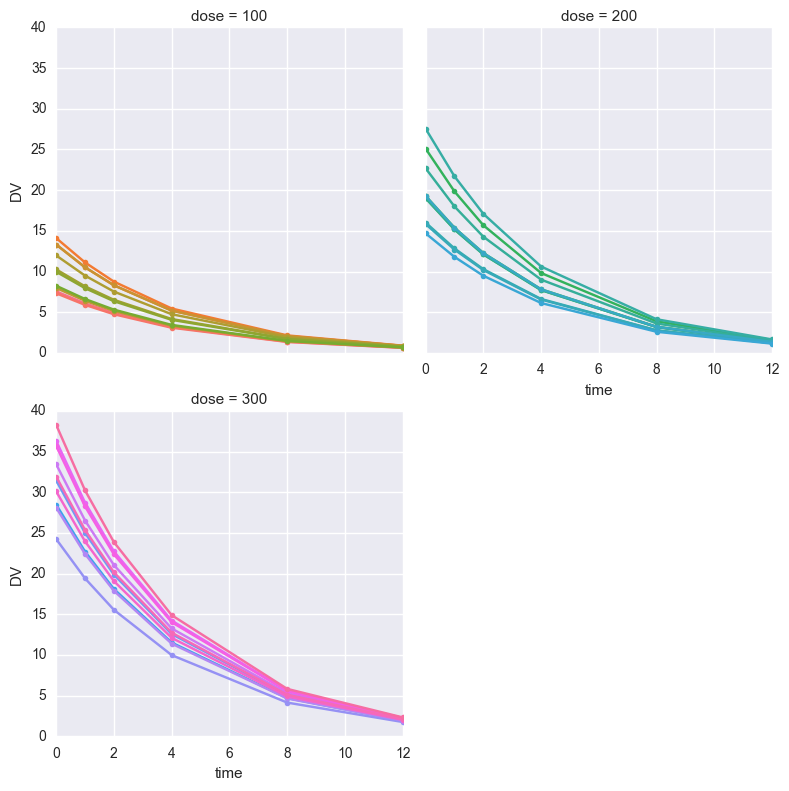

In [45]:
# Visualise data
plasma = sns.FacetGrid(data, col="dose", hue="subject", col_wrap=2, size=4)
plasma.map(plt.plot, "time", "DV", marker="o", ms=4)

In [46]:
# Prepare data from df to model specific arrays
time = np.array(df['time'])
dose = np.array(df['dose'])
DV = np.array(df['DV'])
WT = np.array(df['WT'])
n_patients = len(data['subject'].unique())
subject = data['subject'].values-1

In [47]:
pk_model = Model()

with pk_model:
    # Hyperparameter Priors     
    sigma = Lognormal('sigma', mu =0, tau=0.01)
    
    V = Lognormal('V', mu =2, tau=0.01)
    CL = Lognormal('CL', mu =1, tau=0.01)    
    
    # Transformation wrt to weight
    CLi = CL*(WT)/70    
    Vi = V*(WT)/70

    # Expected value of outcome
    pred = dose/Vi*np.exp(-1*(CLi/Vi)*time)
    
    # Likelihood (sampling distribution) of observations
    conc = Normal('conc', mu =pred, tau=sigma, observed = DV)

         Current function value: -87.562089
         Iterations: 18
         Function evaluations: 209
         Gradient evaluations: 195


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 74.611: 100%|██████████| 200000/200000 [00:22<00:00, 8888.13it/s]
Finished [100%]: Average ELBO = 74.616
100%|██████████| 2000/2000 [00:04<00:00, 475.81it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ce31d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12b79da20>]], dtype=object)

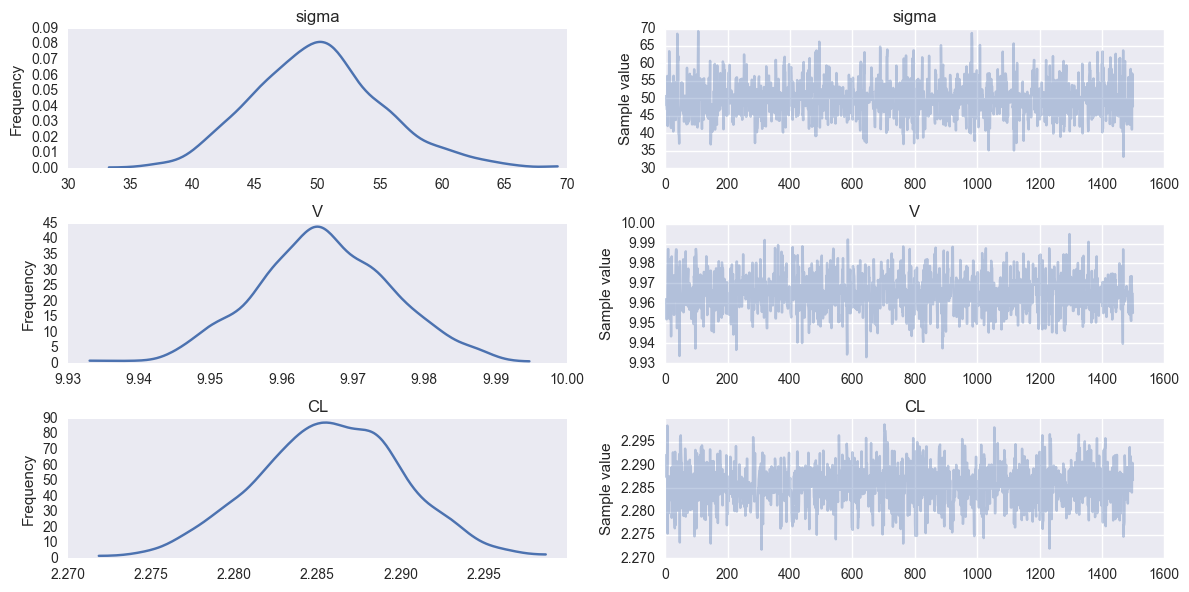

In [48]:
with pk_model:
    # obtain starting values via MAP
    start = find_MAP()    
    # draw 2000 posterior samples
    trace = sample(2000) 
traceplot(trace[500:])

In [43]:
summary(trace)


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  18.377           1.848            0.050            [14.991, 22.193]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  14.922         17.121         18.367         19.574         22.150


V:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.068           0.019            0.000            [10.030, 10.103]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  10.031         10.056         10.068         10.080         10.104


CL:

  Mean             SD               MC Error         95% HPD interval
  --------------------------

In [51]:
pk_model = Model()

with pk_model:
    # Hyperparameter Priors     
    sigma = Lognormal('sigma', mu =0, tau=0.01)
    
    V = Lognormal('V', mu =2, tau=0.01)
    CL = Lognormal('CL', mu =1, tau=0.01)    
    
    # Transformation wrt to weight
    CLi = CL*(WT[subject])/70    
    Vi = V*(WT[subject])/70

    # Expected value of outcome
    pred = dose/Vi*np.exp(-1*(CLi/Vi)*time)
    
    # Likelihood (sampling distribution) of observations
    conc = Normal('conc', mu =pred, tau=sigma, observed = DV)

Optimization terminated successfully.
         Current function value: 474.184245
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -480.68: 100%|██████████| 200000/200000 [00:22<00:00, 8878.31it/s] 
Finished [100%]: Average ELBO = -480.67
100%|██████████| 2000/2000 [00:03<00:00, 625.41it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a60af60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12cdc76a0>]], dtype=object)

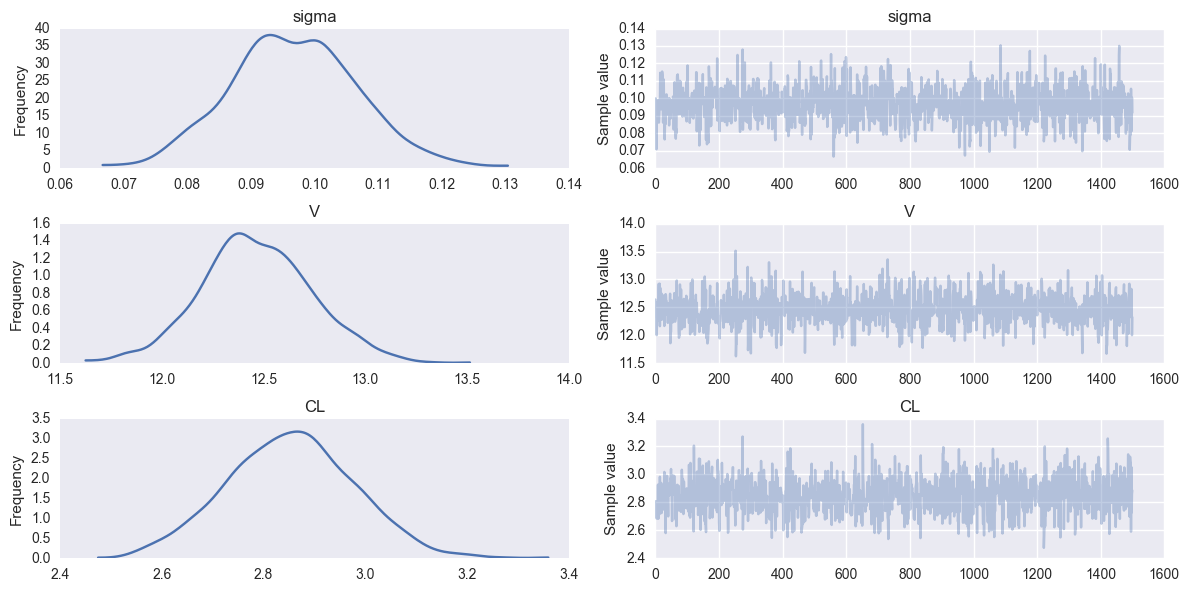

In [52]:
with pk_model:
    # obtain starting values via MAP
    start = find_MAP()    
    # draw 2000 posterior samples
    trace = sample(2000) 
traceplot(trace[500:])

In [53]:
data['CLi'].mean()

2.322473543135788

In [54]:
data['Vi'].mean()

10.147619047619049

In [40]:
summary(trace)


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.167            0.018            0.000            [0.136, 0.205]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.134          0.155          0.167          0.179          0.204


V:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  11.463           0.229            0.006            [11.035, 11.902]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  11.035         11.309         11.465         11.614         11.905


CL:

  Mean             SD               MC Error         95% HPD interval
  -----------------------------